<h1>S&P 500 Analysis</h1>
<p><a href="https://blinks.bloomberg.com/screens/FON NAMEID 8167779">Toby Scholz</a>, April 2020</p>
<p><a href='https://s3.dev.rrdc.bcs.bloomberg.com/global-data-training/data-analysis-with-python/index.html'>Data Analysis with Python - Q4 2019</a></p>

<h2>Questions:</h2>

## [S&P 500 Buy-, Hold-, and Sell recommendations over time](#BHS) ([jump to result](#origResult))
## [How do 2020 trading volumes compare to the 2008 and 1987 financial crises?](#outflows)
## [Was (is) the coronavirus crisis worse than the mortgage crisis?](#inflation)

<h4 style="color:orange;">Global Imports</h4>

In [1]:
#Library imports for all topics
import bql
import numpy as np
import pandas as pd
import seaborn as sns
import math as math
import matplotlib.pyplot as plt
from matplotlib import dates
#import threading
#import multiprocessing
import time
from collections import OrderedDict #not used?
from IPython.display import Markdown, display
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

bq = bql.Service()

<h4 style="color:orange;">Periods</h4>
<ul>
    <li>1987-04-02 - 1987-12-01</li>
    <li>2008-09-02 - 2009-05-01</li>
    <li>2019-09-02 - 2020-05-01</li>
    <li>2003-03-03 - 2017-03-03</li>
</ul></br>
<p><a href="https://en.wikipedia.org/wiki/Black_Monday_(1987)">Black Monday</a>, October 19th 1987, was a comparatively sudden event, during which the <a href="https://blinks.bloomberg.com/screens/INDU Index GP 01/01/1987 01/01/1988">DJIA</a> fell 22.6%, which at that time was the largest single drop in the history of the DJIA.<br/>
<span style="color:pink;">Unfortunately, I was unable to get data for the 1987 period, so I could not include it in this project.</span></p>

<p>The <a href="https://en.wikipedia.org/wiki/Subprime_mortgage_crisis">Subprime Mortgage crisis</a> caused a 0.5% drop in a single day in the <a href="https://blinks.bloomberg.com/screens/SPX Index GP 06/02/2008 06/01/2009">S&P 500</a> on September 30th 2008, followed by a historic low of 676.53 on March 9 2009, the date <a href="https://en.wikipedia.org/wiki/Lehman_Brothers">Lehman Brothers</a> collapsed.</p>

<p>In December 2019, a new strain of <a href="https://en.wikipedia.org/wiki/Coronavirus_disease_2019">Coronavirus</a> emerged in China, leading to a global pandemic. As a result, many governments effectively stopped most business activities by ordering people to stay in their homes.<br/> At the time of writing this analysis, the effects of the lockdown are still playing out, but no doubt, stock markets worldwide were profoundly affected, as the <a href="https://blinks.bloomberg.com/screens/VT US Equity GP 04/23/2019 04/22/2020">Vanguard Global Stocks ETF</a> shows us.</p>

<p>I would like to use the S&P 500 Index to compare the severity of those three profound events.
In addition, I will re-create the S&P 500 Buy, Hold, and Sell chart as per the course assignment, as this involves rather different data processing than the crisis analysis.

The chart in the S&P 500 assignment seems to show the period from March 3 2002 to March 3 2017, although this isn't entirely clear from the screenshot.<br/>
I will try to reproduce this chart as closely as possible</p>

In [2]:
start1987 = datetime(1987,4,2)
end1987 = datetime(1988,1,1)
start2008 = datetime(2008,9,2)
end2008 = datetime(2009,5,1)
start2020 = datetime(2019,9,2)
end2020 = datetime(2020,5,1)
idx = 'SPX Index'

#Looks like the 2007 - 2017 period is too much to request in one so, so we'll work around it later
#startOriginalAssignment = datetime(2007,3,3)
#endOriginalAssignment = datetime(2017,3,3)

#With hindsight, bq.func.range() would have been a more elegant way to do this!

<h2 style="color:orange;"><a id="BHS">S&P 500 Buy-, Hold, and Sell recommendations over time</a></h2>
<p>I included this, as my other two questions don't necessarily need to work with the individual members of the S&P 500</p>

<h4 style="color:orange;">Assumptions</h4>

Of the three above crises, the S&P 500 analysis covers the 2008 mortgage crisis.<br/> 
As a number of firms, particularly in the financial sector, became insolvent during this period, I would expect to see to see a drop in both Buy- and Hold- recommendations, and an increase in Sell recommendations at this time.<br/> Ideally, these should be observable a short time prior to the historic drop of the S&P 500 on September 30, 2008, and again prior to the collapse of Lehman Brothers on March 9, 2009.

In [3]:
#Function to acquire the data from BBG
def getBuyHoldSell(idx, startDate, endDate):
    universe = bq.univ.members(idx)
    params = {"start": startDate, "end": endDate, "fill": "prev"}
    buyRecs = bq.data.tot_buy_rec(**params) 
    holdRecs = bq.data.tot_hold_rec(**params) 
    sellRecs = bq.data.tot_sell_rec(**params) 
    fields = [buyRecs, holdRecs, sellRecs]
    request = bql.Request(universe, fields)
    response = bq.execute(request)
    return bql.combined_df(response)

**Data Acquisition:** Get members of the S&P 500 Index for the 2007 - 2017 period (takes about 10min to run, progress printed to screen)

In [4]:
temp = list()
tasks = list()
startYear = 2003
endYear = 2004
numberOfYears = 14

def getYearByYear(idx, startYear, endYear):
    print("Processing period ", startYear, " - ", endYear)
    startDate = datetime(startYear,3,3)
    endDate = datetime(endYear,3,3)
    temp.append(getBuyHoldSell(idx, startDate, endDate))

#Threaded version, which is throwing an undebuggable error: json.decoder.JSONDecodeError: Expecting ',' delimiter: line 1 column 11777711 (char 11777710)
'''
for i in range(numberOfYears):
    t = threading.Thread(target=getYearByYear, args=(idx, startYear, endYear))
    t.start()
    tasks.append(t)
    startYear +=1
    endYear +=1

for i in tasks:
    i.join()

'''
for i in range(numberOfYears):
    getYearByYear(idx, startYear, endYear)
    startYear +=1
    endYear +=1

for i in temp:
    i.rename(columns={list(i.columns)[1]:'Buy', list(i.columns)[2]:'Hold', list(i.columns)[3]:'Sell'}, inplace=True)
 

resOriginalAssignment = pd.concat(temp)
print("Done")


Processing period  2003  -  2004
Processing period  2004  -  2005
Processing period  2005  -  2006
Processing period  2006  -  2007
Processing period  2007  -  2008
Processing period  2008  -  2009
Processing period  2009  -  2010
Processing period  2010  -  2011
Processing period  2011  -  2012
Processing period  2012  -  2013
Processing period  2013  -  2014
Processing period  2014  -  2015
Processing period  2015  -  2016
Processing period  2016  -  2017
Done


**Inspect the result**

In [5]:
print("****************** 2003 - 2017 ************************")
print(resOriginalAssignment.head(5))
print("\n")
print(resOriginalAssignment.tail(5))
print("\n")
print(resOriginalAssignment.info())
print("\n\n")

****************** 2003 - 2017 ************************
                    DATE  Buy  Hold  Sell
ID                                       
LYB UN Equity        NaT    0     0     0
AXP UN Equity 2003-03-03   11     9     2
AXP UN Equity 2003-03-04   11    10     2
AXP UN Equity 2003-03-05   11    10     2
AXP UN Equity 2003-03-06   11    10     2


                      DATE  Buy  Hold  Sell
ID                                         
DISCK UW Equity 2017-02-27    1     2     0
DISCK UW Equity 2017-02-28    1     2     0
DISCK UW Equity 2017-03-01    1     2     0
DISCK UW Equity 2017-03-02    1     2     0
DISCK UW Equity 2017-03-03    1     2     0


<class 'pandas.core.frame.DataFrame'>
Index: 2307625 entries, LYB UN Equity to DISCK UW Equity
Data columns (total 4 columns):
DATE    datetime64[ns]
Buy     int64
Hold    int64
Sell    int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 88.0+ MB
None





**Exploratory data analysis:** Statistics

In [6]:
def getStatistics(dataFrame):
    print("Average number of Buy recommendations | ", round(dataFrame['Buy'].mean())) # Average
    print("Average number of Hold recommendations | ",round(dataFrame['Hold'].mean()))
    print("Average number of Sell recommendations | ",round(dataFrame['Sell'].mean()))
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Median number of Buy recommendations | ", dataFrame['Buy'].median()) # Median
    print("Median number of Hold recommendations | ",dataFrame['Hold'].median())
    print("Median number of Sell recommendations | ",dataFrame['Sell'].median())
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Standard Deviation of Buy recommendations | ", round(dataFrame['Buy'].std())) #Standard deviation
    print("Standard Deviation of Hold recommendations | ", round(dataFrame['Hold'].std()))
    print("Standard Deviation of Sell recommendations | ", round(dataFrame['Sell'].std()))
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("\n25% - 75% quantiles Buy \n ", dataFrame['Buy'].quantile([0.25, 0.75]))
    print("\n25% - 75% quantiles Hold \n ", dataFrame['Hold'].quantile([0.25, 0.75]))
    print("\n25% - 75% quantiles Sell \n ", dataFrame['Sell'].quantile([0.25, 0.75]))
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Lowest number of Buy recommendations (should be 0) | ", dataFrame['Buy'].min())
    print("Lowest number of Hold recommendations (should be 0) | ", dataFrame['Hold'].min())
    print("Lowest number of Sell recommendations (should be 0) | ", dataFrame['Sell'].min())
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Largest number of Buy recommendations (should be less than 100) | ", dataFrame['Buy'].max())
    print("Largest number of Hold recommendations (should be less than 100) | ", dataFrame['Hold'].max())
    print("Largest number of Sell recommendations (should be less than 100) | ", dataFrame['Sell'].max())
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Summary statistics")
    print(dataFrame.describe()) #Complete Statistics

In [7]:
print(getStatistics(resOriginalAssignment))

Average number of Buy recommendations |  9.0
Average number of Hold recommendations |  8.0
Average number of Sell recommendations |  1.0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Median number of Buy recommendations |  8.0
Median number of Hold recommendations |  7.0
Median number of Sell recommendations |  0.0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Standard Deviation of Buy recommendations |  7.0
Standard Deviation of Hold recommendations |  5.0
Standard Deviation of Sell recommendations |  1.0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


25% - 75% quantiles Buy 
  0.25     4.0
0.75    13.0
Name: Buy, dtype: float64

25% - 75% quantiles Hold 
  0.25     4.0
0.75    11.0
Name: Hold, dtype: float64

25% - 75% quantiles Sell 
  0.25    0.0
0.75    1.0
Name: Sell, dtype: float64

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

**Data Wrangling:** Cleaning up the data set

When I ran this, the avergage number of Buy recommendations was 9, the maximum 55. Hold and Sell recommendation were all together lower numbers.
To prevent unclean data, I propose:
* Cull any recommendations < 0, since this would not make sense
* Cull any recommendations > 100, as they are likely outliers (there cannot be more recommendations than there are analysts)


In [8]:
def processDataframe(dataFrame):
    processedDataframe = dataFrame
    maxNumberOfExpectedRecommendations = 100
    
    #Get rid of N/As and outliers
    processedDataframe.dropna(how='any', inplace=True) #Remove any rows that have N/A values (there should be none, as worst case, a stock can have 0 recommendations)
    processedDataframe[(processedDataframe['Buy'] >= 0) | (processedDataframe['Buy'] < maxNumberOfExpectedRecommendations)]
    processedDataframe[(processedDataframe['Hold'] >= 0) | (processedDataframe['Hold'] < maxNumberOfExpectedRecommendations)]
    processedDataframe[(processedDataframe['Sell'] >= 0) | (processedDataframe['Sell'] < maxNumberOfExpectedRecommendations)]
    
    #Put the date into a format that pyplot can understand
    format = '%Y-%m-%d %H:%M:%S'
    processedDataframe['DATE'] = pd.to_datetime(processedDataframe['DATE'], format=format, errors='ignore')
    processedDataframe.set_index(pd.DatetimeIndex(processedDataframe['DATE']), inplace=True)
    processedDataframe.drop(columns=['DATE'], inplace=True)
    return processedDataframe


dataOriginal = processDataframe(resOriginalAssignment)

In [9]:
#Sanity check
print(dataOriginal.index.max())
print(dataOriginal.index.min())

2017-03-03 00:00:00
2003-03-03 00:00:00


Having cleaned up the dataset, we need to put it into a useful format.<br/>
The chart from the assignment actually looks at percentages, so let's do that here as well.

In [10]:
#Sum up all recommendations for a given day
aggregatedDataOriginal = dataOriginal.groupby('DATE')[['Buy','Hold','Sell']].sum()

#Create a column for the total number of recommendations per day
aggregatedDataOriginal['Total'] = aggregatedDataOriginal.sum(axis=1)

#Create a percentage column for each Buy / Hold / Sell
aggregatedDataOriginal['BuyPercent'] = (aggregatedDataOriginal['Buy'] / aggregatedDataOriginal['Total'])*100
aggregatedDataOriginal['HoldPercent'] = (aggregatedDataOriginal['Hold'] / aggregatedDataOriginal['Total'])*100
aggregatedDataOriginal['SellPercent'] = (aggregatedDataOriginal['Sell'] / aggregatedDataOriginal['Total'])*100

#Sanity check
print(aggregatedDataOriginal.head(5))
#print(aggregatedData2008.sample(frac=0.5, replace=True, random_state=1)) #Tech chat question

             Buy  Hold  Sell  Total  BuyPercent  HoldPercent  SellPercent
DATE                                                                     
2003-03-03  2604  2442   494   5540   47.003610    44.079422     8.916968
2003-03-04  2608  2442   494   5544   47.041847    44.047619     8.910534
2003-03-05  2611  2441   495   5547   47.070489    44.005769     8.923743
2003-03-06  2608  2441   497   5546   47.024883    44.013704     8.961414
2003-03-07  2605  2439   498   5542   47.004691    44.009383     8.985926


<h4 style="color:orange;"><a id="origResult">Reproduction of Assignment Graph</a></h4>

1st attempt: Single chart (no broken X axis)

<span style="font-weight:bold;font-size:2em;color:white;">S&P Percent Buy, Hold, Sells</span>

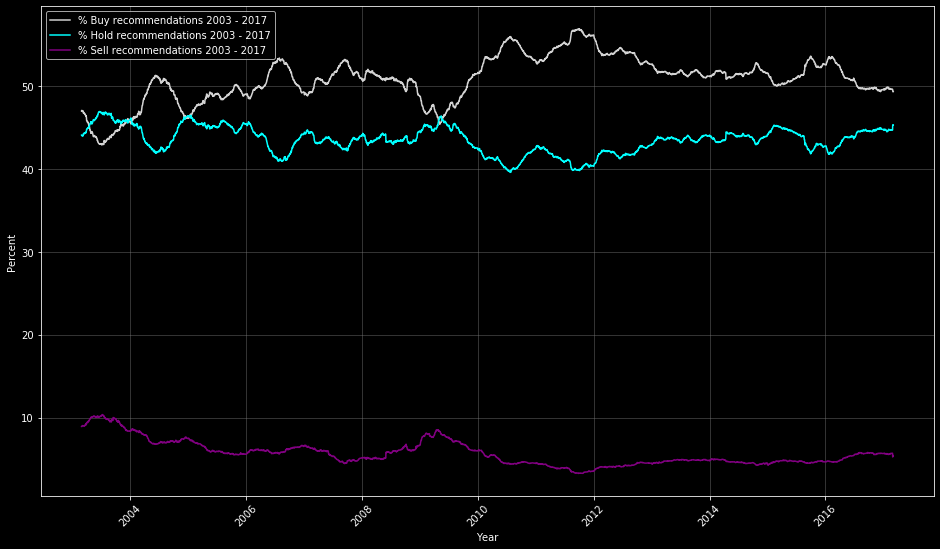

In [11]:
display(Markdown('<span style="font-weight:bold;font-size:2em;color:white;">S&P Percent Buy, Hold, Sells</span>')) #Title

plt.style.use('dark_background')
plt.figure(figsize=(16,9)) #bigger is better
plt.xlabel("Year")
plt.ylabel("Percent")
plt.rcParams['ytick.labelright'] = True
plt.xticks(rotation="45")
plt.grid(linestyle = '-', zorder=3, color='grey',alpha=0.5)

plt.plot(aggregatedDataOriginal[['BuyPercent']], color='lightgrey', label="% Buy recommendations 2003 - 2017")
plt.plot(aggregatedDataOriginal[['HoldPercent']], color='cyan', label="% Hold recommendations 2003 - 2017")
plt.plot(aggregatedDataOriginal[['SellPercent']], color='purple', label="% Sell recommendations 2003 - 2017")
plt.legend(loc="upper left")
plt.tick_params(labeltop=False)

2nd attempt: Including subplots, to facilitate the broken Y axis

<span style="font-weight:bold;font-size:2em;color:white;">S&P Percent Buy, Hold, Sells</span>

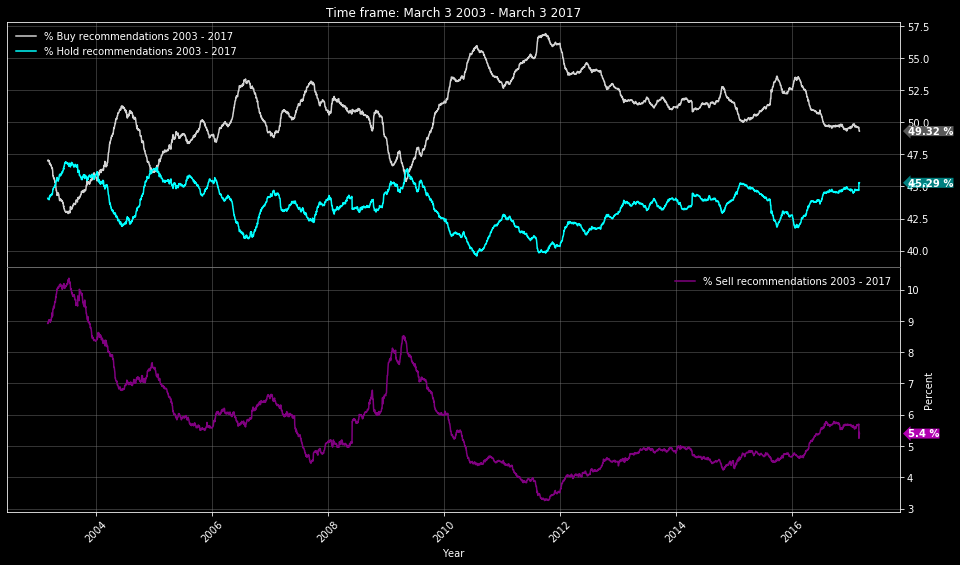

In [12]:
display(Markdown('<span style="font-weight:bold;font-size:2em;color:white;">S&P Percent Buy, Hold, Sells</span>')) #Title

#Create two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,9))
plt.subplots_adjust(hspace=0)

#Set titles and labels
ax1.set_title('Time frame: March 3 2003 - March 3 2017')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percent')

#Format the spines, so the two plots effectively become one
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_color('grey')

#Some formatting better looks
plt.style.use('dark_background')
plt.rcParams['ytick.labelright'] = True
ax1.grid(linestyle = '-', zorder=3, color='grey',alpha=0.5)
ax2.grid(linestyle = '-', zorder=3, color='grey',alpha=0.5)
plt.xticks(rotation="45")

#Plotting the data
ax1.plot(aggregatedDataOriginal[['BuyPercent']], color='lightgrey', label="% Buy recommendations 2003 - 2017")
ax1.plot(aggregatedDataOriginal[['HoldPercent']], color='cyan', label="% Hold recommendations 2003 - 2017")
ax2.plot(aggregatedDataOriginal[['SellPercent']], color='purple', label="% Sell recommendations 2003 - 2017")

#Add labels and legends

ax2.legend(loc="upper right", frameon=False)
ax1.legend(loc="upper left", frameon=False)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

#Add annotations, to emulate the arrows we see on the very right of the screenshot
bbox_props1 = dict(boxstyle="larrow,pad=0.0", fc="grey", ec="b", lw=0, alpha=0.7)
text1 = str(round(np.asscalar(aggregatedDataOriginal[['BuyPercent']].values[-1]),2)) + ' %'
t = ax1.text(datetime(2018,1,3),aggregatedDataOriginal[['BuyPercent']].values[-1], text1, ha="left", va="center", rotation=0, size=10, bbox=bbox_props1, fontweight='bold')

bbox_props2 = dict(boxstyle="larrow,pad=0.0", fc="cyan", ec="b", lw=0, alpha=0.5)
text2 = str(round(np.asscalar(aggregatedDataOriginal[['HoldPercent']].values[-1]),2)) + ' %'
t = ax1.text(datetime(2018,1,3),aggregatedDataOriginal[['HoldPercent']].values[-1], text2, ha="left", va="center", rotation=0, size=10, bbox=bbox_props2, fontweight='bold')

bbox_props3 = dict(boxstyle="larrow,pad=0.0", fc="magenta", ec="b", lw=0, alpha=0.7)
text3 = str(round(np.asscalar(aggregatedDataOriginal[['SellPercent']].values[-1]),2)) + ' %'
t = ax2.text(datetime(2018,1,3),aggregatedDataOriginal[['SellPercent']].values[-1], text3, ha="left", va="center", rotation=0, size=10, bbox=bbox_props3, fontweight='bold')


Original screenshot for comparison

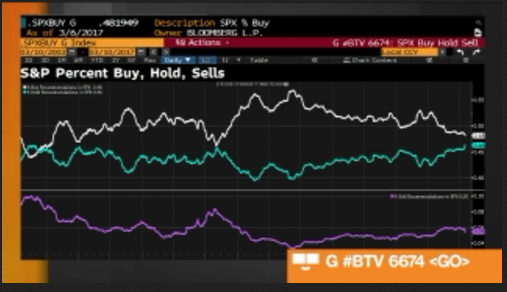


<h4 style="color:orange;">Conclusion</h4>
<p>This is as close as I can get to the screenshot in the assignment for now.<br/>
I noticed the grid in the original has larger increments, and there is less space between the vertical borders and the beginning / end of the data.</p>

<p>It is somewhat reassuring to see that there is an inverse correlation between buy- and sell recommendations, and given the comparative boom we experienced during the period in question, it is probably right that the trend was moving towards more buy recommendations overall towrds the end of the period.</p>

<p>It makes less sense to me that hold recommendations inversely correlate with sell recommendations - are these optimistic analysts changing their buys to holds instead of sells?</p>

<p>I was surprised to see the relative lag in response to the two fundamental market events, September 30, 2008, and March  9, 2009. While there is a general trend for Buy recommendations to drop throughout 2008, there is an overall increase in Hold recommendations, up until March 9, 2009. This seems to show that market analysts are behind, rather than ahead, of the market with their recommendations. 
It is probably correct that analysts identified an undervalued market overall after the Lehman collapse, where we see a sharp increase in Buy recommendations, and a drop in Hold- and Sell- recommendations. Again, this trend plays out over approximately two years, which seems to indicate that market analysts are following the market, not predicting it.</p>

<p>Overall, it is interesting to see that there are far fewer Sell recommendations compared to Buy- and Hold recommendations. This could be reflecting the general desire for the market to go "up", which is also manifested in stock market circuit breakers (which only operate in a downward direction), and the requirement for inflation to finance retirement and debt.</p>

In [13]:
plt.close() #Tidy up

<p></p>
<h2 style="color:orange;"><a id="outflows">Trading Volumes</a></h2>

<p>I am interested to see how key events trigger trading flows. </p>
<p>Since the MarketCap of the S&P 500 has changed significantly between 2008 and 2020, I think it makes more sense to look at the trading volume as percentage of MarketCap to compare the two years.</p>
<p>This will still give a slightly skewed view (as a large drop in MarketCap will make the same trading volume look larger), however.</p>

In [14]:
#Get the data
def getVolumeAndMarketCap(idx, startDate, endDate):
    params = {"start": startDate, "end": endDate, "fill": "prev"}
    px_volume = bq.data.px_volume(**params) 
    indx_market_cap = bq.data.cur_mkt_cap(**params) 
    fields = [px_volume, indx_market_cap]
    request = bql.Request('SPX Index', fields)
    response = bq.execute(request)
    one = response[0].df()
    two = response[1].df()
    one.dropna(how='any', inplace=True)
    two.dropna(how='any', inplace=True)
    one.rename(columns={list(one.columns)[1]:'Volume'}, inplace=True)
    two.rename(columns={list(two.columns)[2]:'MarketCap'}, inplace=True)
    two.drop(two.columns[1], axis=1, inplace=True)
    format = '%Y-%m-%d %H:%M:%S'
    one['DATE'] = pd.to_datetime(one['DATE'], format=format, errors='ignore')
    two['DATE'] = pd.to_datetime(two['DATE'], format=format, errors='ignore')
    processedDataframe =  pd.merge(one, two, how='inner', left_on='DATE', right_on='DATE')
    #Add column for Trading Volume in bips 
    processedDataframe['VolumeBips'] = (processedDataframe['Volume'] / processedDataframe['MarketCap'])*10000 #Basis points
    #Convert MarketCap into $bn (short scale)
    processedDataframe['MarketCap'] = processedDataframe['MarketCap']/1000000000 #billion dollars
    #Convert Traded Volume into $m 
    processedDataframe['Volume'] = processedDataframe['Volume']/1000000 #million dollars
    
    processedDataframe.set_index(pd.DatetimeIndex(processedDataframe['DATE']), inplace=True)
    processedDataframe.drop(columns=['DATE'], inplace=True)
    return processedDataframe

    
res2020 = getVolumeAndMarketCap(idx, start2020, end2020)
res2008 = getVolumeAndMarketCap(idx, start2008, end2008)
#res1987 = getVolumeAndMarketCap(idx, start1987, end1987) #Unfortunately, we don't get any data back for 1987 :(


In [15]:
#Sanity check
print("****************** 2020 ************************")
print(res2020.head(5))
print("\n")
print(res2020.tail(5))
print("\n")
print(res2020.info())
print("\n\n")
print("****************** 2008 ************************")
print(res2008.head(5))
print("\n")
print(res2008.tail(5))
print("\n")
print(res2008.info())
print("\n\n")
#print("****************** 1987 ************************")
#print(res1987.head(5))
#print("\n")
#print(res1987.tail(5))
#print("\n")
#print(res1987.info())
#print("\n\n")

****************** 2020 ************************
                Volume     MarketCap  VolumeBips
DATE                                            
2019-09-02  532.980531  25268.149117    0.210930
2019-09-03  489.524393  25096.288802    0.195058
2019-09-04  449.778606  25367.917925    0.177302
2019-09-05  535.529513  25695.844609    0.208411
2019-09-06  445.306999  25717.944159    0.173150


                Volume     MarketCap  VolumeBips
DATE                                            
2020-04-27  610.804555  24845.814663    0.245838
2020-04-28  669.664018  24709.914020    0.271010
2020-04-29  669.664018  24709.914020    0.271010
2020-04-30  669.664018  24709.914020    0.271010
2020-05-01  669.664018  24709.914020    0.271010


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2019-09-02 to 2020-05-01
Data columns (total 3 columns):
Volume        243 non-null float64
MarketCap     243 non-null float64
VolumeBips    243 non-null float64
dtypes: float64(3)
memory usage: 

Get statistics

In [16]:
def getStats(dataFrame):
    print("Average Trading Volume | ", round(dataFrame['Volume'].mean())) # Average
    print("Average Index Market Capitaliztion | ",round(dataFrame['MarketCap'].mean()))
    print("Average Trading Volume in basis point | ", round(dataFrame['VolumeBips'].mean())) 
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Median number of Trading Volume | ", dataFrame['Volume'].median()) # Median
    print("Median Index Market Capitaliztion | ",dataFrame['MarketCap'].median())
    print("Median Volume in basis point | ", round(dataFrame['VolumeBips'].median()))
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Standard Deviation of Trading Volume | ", round(dataFrame['Volume'].std())) #Standard deviation
    print("Standard Deviation of Index Market Capitaliztion| ", round(dataFrame['MarketCap'].std()))
    print("Standard Deviation of Volume in basis point | ", round(dataFrame['VolumeBips'].std()))
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("\n25% - 75% quantiles Trading Volume \n ", dataFrame['Volume'].quantile([0.25, 0.75]))
    print("\n25% - 75% quantiles Index Market Capitaliztion \n ", dataFrame['MarketCap'].quantile([0.25, 0.75]))
    print("\n25% - 75% quantiles Trading Volume in basis points \n ", dataFrame['VolumeBips'].quantile([0.25, 0.75]))
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Lowest number of Trading Volume | ", dataFrame['Volume'].min())
    print("Lowest number of Index Market Capitaliztion | ", dataFrame['MarketCap'].min())
    print("Lowest number of Trading Volume in Bips | ", dataFrame['VolumeBips'].min())
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Largest number of Trading Volume | ", dataFrame['Volume'].max())
    print("Largest number Index Market Capitaliztion | ", dataFrame['MarketCap'].max())
    print("Largest number of Trading Volume in Bips | ", dataFrame['VolumeBips'].max())
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    print("Summary statistics")
    print(dataFrame.describe()) #Complete Statistics

In [17]:
print('+++++++++++++++ 2020 +++++++++++++++++++')
print(getStats(res2020))
print('+++++++++++++++ 2008 +++++++++++++++++++') 
print(getStats(res2008))
#print(getStats(res1987)) No data available


+++++++++++++++ 2020 +++++++++++++++++++
Average Trading Volume |  686.0
Average Index Market Capitaliztion |  26100.0
Average Trading Volume in basis point |  0.0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Median number of Trading Volume |  543.535029
Median Index Market Capitaliztion |  26256.416367154
Median Volume in basis point |  0.0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Standard Deviation of Trading Volume |  335.0
Standard Deviation of Index Market Capitaliztion|  2106.0
Standard Deviation of Volume in basis point |  0.0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


25% - 75% quantiles Trading Volume 
  0.25    476.855596
0.75    796.066509
Name: Volume, dtype: float64

25% - 75% quantiles Index Market Capitaliztion 
  0.25    25388.394196
0.75    27795.093544
Name: MarketCap, dtype: float64

25% - 75% quantiles Trading Volume in basis 

The <span style="color:pink">subrpime mortgage crisis</span> in 2008 had two key events, the Dow Jones Industrial Avergae crash on September 30, 2008, and the collapse of Lehman Brothers on March 9 2009, both of which are highlighted in the charts below

The <span style="color:pink">Coronavirus pandemic</span> is developing more gradually.<br/>
The New York Times helpfully published a <a href="https://www.nytimes.com/article/coronavirus-timeline.html">timeline of events</a> related to the coronavirus pandemic.<br/>
I have selected a few key events, which are marked both on the graphs, and in the table below (in yellow).

<table class="table table-bordered table-hover table-condensed">
<thead><tr><th title="Field #1" style="width:15%">Date</th>
<th title="Field #2" style="width:85%">Event</th>
</tr></thead>
<tbody><tr>
<td>Dec-31</td>
<td>Chinese authorities treated dozens of cases of pneumonia of unknown cause.</td>
</tr>
<tr>
<td>Jan-11</td>
<td>China reported its first death.</td>
</tr>
<tr>
<td>Jan-20</td>
<td>Other countries, including the United States, confirmed cases.</td>
</tr>
<tr>
<td>Jan-23</td>
<td>Wuhan, a city of more than 11 million, was cut off by the Chinese authorities.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold" >Jan-30</td>
<td style="color:yellow; font-weight:bold">The W.H.O. declared a global health emergency.</td>
</tr>
<tr>
<td>Jan-31</td>
<td>The Trump administration restricted travel from China</td>
</tr>
<tr>
<td>Feb-02</td>
<td>The first coronavirus death was reported outside China.</td>
</tr>
<tr>
<td>Feb-05</td>
<td>A cruise ship in Japan quarantined thousands.</td>
</tr>
<tr>
<td>Feb-07</td>
<td>A Chinese doctor who tried to raise the alarm died.</td>
</tr>
<tr>
<td>Feb-11</td>
<td>The disease the virus causes was named.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Feb-14</td>
<td style="color:yellow; font-weight:bold">France announces the first coronavirus death in Europe.</td>
</tr>
<tr>
<td>Feb-19</td>
<td>Hundreds leave the quarantined cruise.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Feb-21</td>
<td style="color:yellow; font-weight:bold">A secretive church is linked to the outbreak in South Korea.</td>
</tr>
<tr>
<td></td>
<td style="color:yellow; font-weight:bold">The virus appears in Iran from an unknown source.</td>
</tr>
<tr>
<td>Feb-23</td>
<td>Italy sees major surge in  cases and officials lock down towns.</td>
</tr>
<tr>
<td>Feb-24</td>
<td>The Trump administration asks Congress for $1.25 billion for coronavirus response.</td>
</tr>
<tr>
<td></td>
<td>Iran emerges as a second focus point.</td>
</tr>
<tr>
<td>Feb-26</td>
<td>Latin America reports its first  case.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Feb-28</td>
<td style="color:yellow; font-weight:bold">Infections in Europe spike.</td>
</tr>
<tr>
<td></td>
<td style="color:yellow; font-weight:bold">Sub-Saharan Africa records its first infection.</td>
</tr>
<tr>
<td>Feb-29</td>
<td>The United States first reports a coronavirus death and announces travel restrictions.</td>
</tr>
<tr>
<td>Mar-03</td>
<td>U.S. officials approve widespread coronavirus testing.</td>
</tr>
<tr>
<td>Mar-11</td>
<td>President Trump blocks most visitors from continental Europe.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Mar-13</td>
<td style="color:yellow; font-weight:bold">President Trump declares a national emergency.</td>
</tr>
<tr>
<td>Mar-15</td>
<td>The C.D.C. recommends no gatherings of 50 or more people in the U.S.</td>
</tr>
<tr>
<td>Mar-16</td>
<td>Latin America begins to feel the effects of the virus.</td>
</tr>
<tr>
<td>Mar-17</td>
<td>France imposes a nationwide lockdown.</td>
</tr>
<tr>
<td></td>
<td>The E.U. bars most travelers from outside the bloc for 30 days.</td>
</tr>
<tr>
<td>Mar-19</td>
<td>For the first time, China reports zero local infections.</td>
</tr>
<tr>
<td>Mar-21</td>
<td>Hawaii orders a mandatory 14-day quarantine to arriving visitors and residents.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Mar-23</td>
<td style="color:yellow; font-weight:bold">Prime Minister Boris Johnson locks Britain down.</td>
</tr>
<tr>
<td>Mar-24</td>
<td>The Tokyo Olympics delayed until 2021.</td>
</tr>
<tr>
<td></td>
<td>India, a country of 1.3 billion, announces a 21-day lockdown.</td>
</tr>
<tr>
<td>Mar-26</td>
<td>The United States leads the world in confirmed coronavirus cases.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Mar-27</td>
<td style="color:yellow; font-weight:bold">Trump signs coronavirus stimulus bill into law.</td>
</tr>
<tr>
<td>Mar-28</td>
<td>The C.D.C. issues a travel advisory for the New York region.</td>
</tr>
<tr>
<td>Mar-30</td>
<td>More states issue stay-at-home directives.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Apr-02</td>
<td style="color:yellow; font-weight:bold">Global cases top one million, and millions lose their jobs.</td>
</tr>
<tr>
<td>Apr-06</td>
<td>Prime Minister Boris Johnson moved into intensive care.</td>
</tr>
<tr>
<td>Apr-08</td>
<td>Companies plan and start vaccine trials.</td>
</tr>
<tr>
<td>Apr-10</td>
<td>Global  deaths surpass 101,000.</td>
</tr>
<tr>
<td></td>
<td>Coronavirus cases surge in Russia.</td>
</tr>
<tr>
<td>Apr-12</td>
<td>Boris Johnson is released from the hospital.</td>
</tr>
<tr>
<td>Apr-13</td>
<td>Some European nations begin easing restrictions.</td>
</tr>
<tr>
<td style="color:yellow; font-weight:bold">Apr-14</td>
<td style="color:yellow; font-weight:bold">President Trump plans to stop U.S. funding of the W.H.O.</td>
</tr>
<tr>
<td></td>
<td style="color:yellow; font-weight:bold">The global economy slides toward contraction.</td>
</tr>
<tr>
<td>Apr-16</td>
<td>Brazil’s president fires the health minister.</td>
</tr>
<tr>
<td>Apr-17</td>
<td>President Trump encourages protests against some state restrictions.</td>
</tr>
<tr>
<td>Apr-19</td>
<td>Chile issues ‘immunity cards’ to people who have recovered from the virus.</td>
</tr>
<tr>
<td>Apr-20</td>
<td>President Trump announced an order suspending immigration.</td>
</tr>
<tr>
<td>Apr-21</td>
<td>Officials discover earlier known U.S. coronavirus deaths in California.</td>
</tr>
</tbody></table>

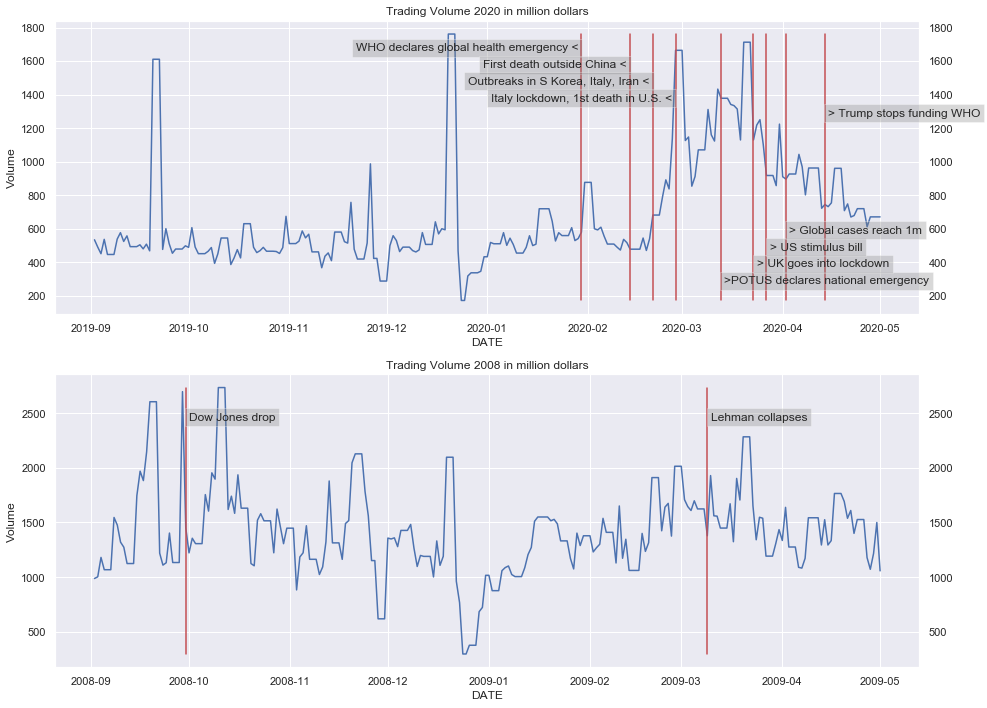

In [18]:
#A scatterplot may also work here, but is harder to read
sns.set(rc={'figure.figsize':(14,10)}) #Make the graph bigger

fig, ax = plt.subplots(2)
xdata = np.arange(50)
sns.set(style="ticks")
g1 = sns.relplot(x='DATE', y='Volume', kind='line',  data=res2020.reset_index(), ax=ax[0])
g2 = sns.relplot(x='DATE', y='Volume', kind='line',  data=res2008.reset_index(), ax=ax[1])
ax[0].set_title("Trading Volume 2020 in million dollars")
ax[1].set_title("Trading Volume 2008 in million dollars")

#Annotations
ax[0].plot([datetime(2020,1,30),datetime(2020,1,30)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,1,29), max(res2020['Volume']-100), 'WHO declares global health emergency <',  ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,14),datetime(2020,2,14)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,2,13), max(res2020['Volume']-200), 'First death outside China <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,21),datetime(2020,2,21)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,2,20), max(res2020['Volume']-300), 'Outbreaks in S Korea, Italy, Iran <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,28),datetime(2020,2,28)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,2,27), max(res2020['Volume']-400), 'Italy lockdown, 1st death in U.S. <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,13),datetime(2020,3,13)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,3,14), min(res2020['Volume']+100), '>POTUS declares national emergency', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,23),datetime(2020,3,23)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,3,24), min(res2020['Volume']+200), '> UK goes into lockdown', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,27),datetime(2020,3,27)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,3,28), min(res2020['Volume']+300), '> US stimulus bill', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,4,2),datetime(2020,4,2)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,4,3), min(res2020['Volume']+400), '> Global cases reach 1m', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,4,14),datetime(2020,4,14)], [min(res2020['Volume']),max(res2020['Volume'])], color='r') 
ax[0].text(datetime(2020,4,15), min(res2020['Volume']+1100), '> Trump stops funding WHO', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 

ax[1].plot([datetime(2008,9,30),datetime(2008,9,30)], [min(res2008['Volume']),max(res2008['Volume'])], color='r') #DJII
ax[1].text(datetime(2008,10,1), max(res2008['Volume']-300), 'Dow Jones drop', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[1].plot([datetime(2009,3,9),datetime(2009,3,9)], [min(res2008['Volume']),max(res2008['Volume'])], color='r') #Lehman
ax[1].text(datetime(2009,3,10), max(res2008['Volume']-300), 'Lehman collapses', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 

# Close the additional empty figures returned by replot
plt.close(g1.fig)
plt.close(g2.fig) 
plt.tight_layout()

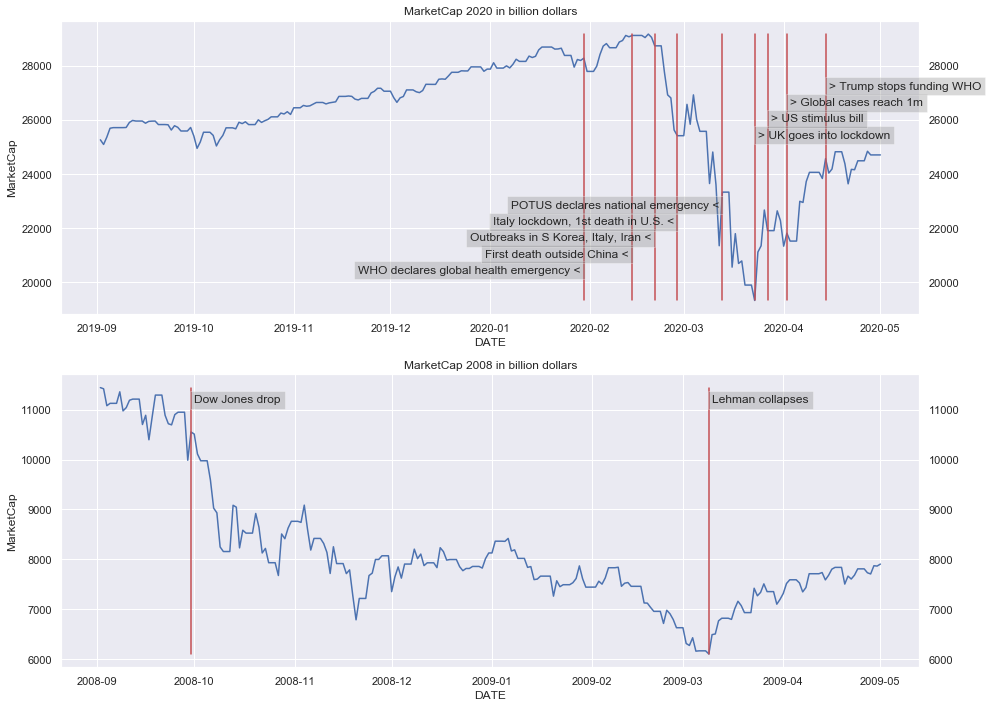

In [19]:
sns.set(rc={'figure.figsize':(14,10)})

fig, ax = plt.subplots(2)
xdata = np.arange(50)
sns.set(style="ticks")
g1 = sns.relplot(x='DATE', y='MarketCap', kind='line',  data=res2020.reset_index(), ax=ax[0])
g2 = sns.relplot(x='DATE', y='MarketCap', kind='line',  data=res2008.reset_index(), ax=ax[1])
ax[0].set_title("MarketCap 2020 in billion dollars")
ax[1].set_title("MarketCap 2008 in billion dollars")

#Annotations
ax[0].plot([datetime(2020,1,30),datetime(2020,1,30)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,1,29), min(res2020['MarketCap']+1000), 'WHO declares global health emergency <',  ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,14),datetime(2020,2,14)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,2,13), min(res2020['MarketCap']+1600), 'First death outside China <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,21),datetime(2020,2,21)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,2,20), min(res2020['MarketCap']+2200), 'Outbreaks in S Korea, Italy, Iran <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,28),datetime(2020,2,28)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,2,27), min(res2020['MarketCap']+2800), 'Italy lockdown, 1st death in U.S. <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,13),datetime(2020,3,13)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,3,12), min(res2020['MarketCap']+3400), 'POTUS declares national emergency <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,23),datetime(2020,3,23)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,3,24), min(res2020['MarketCap']+6000), '> UK goes into lockdown', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,27),datetime(2020,3,27)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,3,28), min(res2020['MarketCap']+6600), '> US stimulus bill', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,4,2),datetime(2020,4,2)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,4,3), min(res2020['MarketCap']+7200), '> Global cases reach 1m', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,4,14),datetime(2020,4,14)], [min(res2020['MarketCap']),max(res2020['MarketCap'])], color='r') 
ax[0].text(datetime(2020,4,15), min(res2020['MarketCap']+7800), '> Trump stops funding WHO', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 

ax[1].plot([datetime(2008,9,30),datetime(2008,9,30)], [min(res2008['MarketCap']),max(res2008['MarketCap'])], color='r') #DJII
ax[1].text(datetime(2008,10,1), max(res2008['MarketCap']-300), 'Dow Jones drop', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[1].plot([datetime(2009,3,9),datetime(2009,3,9)], [min(res2008['MarketCap']),max(res2008['MarketCap'])], color='r') #Lehman
ax[1].text(datetime(2009,3,10), max(res2008['MarketCap']-300), 'Lehman collapses', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 

# Close the additional empty figures returned by replot
plt.close(g1.fig)
plt.close(g2.fig) 
plt.tight_layout()

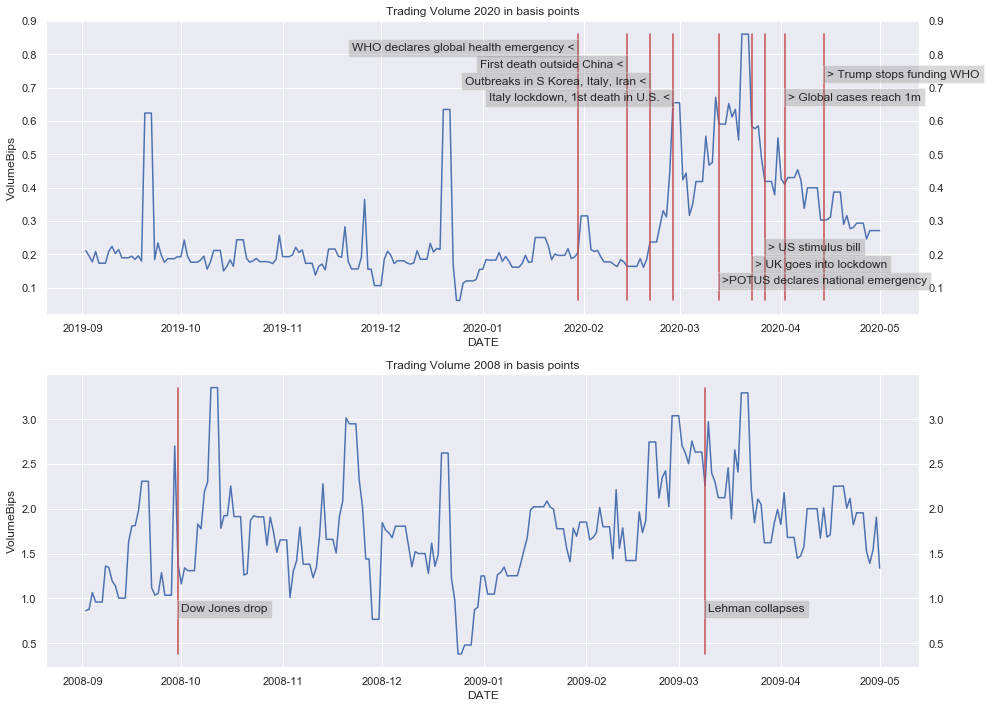

In [20]:
sns.set(rc={'figure.figsize':(14,10)}) #Make the graph bigger

fig, ax = plt.subplots(2)
xdata = np.arange(50)
sns.set(style="ticks")
g1 = sns.relplot(x='DATE', y='VolumeBips', kind='line',  data=res2020.reset_index(), ax=ax[0])
g2 = sns.relplot(x='DATE', y='VolumeBips', kind='line',  data=res2008.reset_index(), ax=ax[1])
ax[0].set_title("Trading Volume 2020 in basis points")
ax[1].set_title("Trading Volume 2008 in basis points")

#Annotations
ax[0].plot([datetime(2020,1,30),datetime(2020,1,30)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,1,29), max(res2020['VolumeBips']-0.05), 'WHO declares global health emergency <',  ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,14),datetime(2020,2,14)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,2,13), max(res2020['VolumeBips']-0.1), 'First death outside China <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,21),datetime(2020,2,21)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,2,20), max(res2020['VolumeBips']-0.15), 'Outbreaks in S Korea, Italy, Iran <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,2,28),datetime(2020,2,28)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,2,27), max(res2020['VolumeBips']-0.2), 'Italy lockdown, 1st death in U.S. <', ha='right', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,13),datetime(2020,3,13)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,3,14), min(res2020['VolumeBips']+0.05), '>POTUS declares national emergency', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,23),datetime(2020,3,23)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,3,24), min(res2020['VolumeBips']+0.1), '> UK goes into lockdown', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,3,27),datetime(2020,3,27)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,3,28), min(res2020['VolumeBips']+0.15), '> US stimulus bill', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,4,2),datetime(2020,4,2)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,4,3), min(res2020['VolumeBips']+0.6), '> Global cases reach 1m', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[0].plot([datetime(2020,4,14),datetime(2020,4,14)], [min(res2020['VolumeBips']),max(res2020['VolumeBips'])], color='r') 
ax[0].text(datetime(2020,4,15), min(res2020['VolumeBips']+0.67), '> Trump stops funding WHO', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 

ax[1].plot([datetime(2008,9,30),datetime(2008,9,30)], [min(res2008['VolumeBips']),max(res2008['VolumeBips'])], color='r') #DJII
ax[1].text(datetime(2008,10,1), max(res2008['VolumeBips']-2.5), 'Dow Jones drop', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 
ax[1].plot([datetime(2009,3,9),datetime(2009,3,9)], [min(res2008['VolumeBips']),max(res2008['VolumeBips'])], color='r') #Lehman
ax[1].text(datetime(2009,3,10), max(res2008['VolumeBips']-2.5), 'Lehman collapses', bbox=dict(facecolor='grey', alpha=0.3, zorder=1)) 

# Close the additional empty figures returned by replot
plt.close(g1.fig)
plt.close(g2.fig) 
plt.tight_layout()

<h4 style="color:orange;">Observations</h4>
<p>In 2020, the S&P 500 Index dropped from a high of 3386.15 (Feburary 19th 2020) to a low of 2237.40 (March 23rd 2020), approximately a 34% drop, before recovering.<br/>
In 2008, the S&P 500 Index dropped from a high of 1277.58 (September 2nd, 2008) to a low of 676.53 (March 9th, 2009), approximately a 47% drop, before recovering.</p>

<p>The highest trading volume we see in 2020 is on the 20th of March, equating to just under 1 basis point of the Market Capitalization of the S&P 500 Index at that time<br/>
The highest trading volume we see in 2008 is on the 10th of October, equating to just under 3.4 basis points of the Market Capitalization of the S&P 500 Index at that time.</p>

<p>While the 23rd of March is widely touted as the most significant date in the current crisis (Tokyo Olympics delayed, India annouces lockdown, UK's first day of lockdown), the S&P 500 seems to suggest it is actually the 13th of March, which is the day on which the president of the United States declared a national emergency.<br/>
This was a Friday -  the following week (16th - 20th of March) saw the highest outflows, with trading volumes reaching 0.85 basis points of market
cap on the 20th of March, and the MarketCap dropping at it's sharpest level, from 23.335tn on the 13th of March to 19.334tn on the 23rd of March
(a 17% drop), before recovering.<br/></p>

<p>The key date for 2008 seems to be the 19th of October, which saw trading flows of nearly 3 basis points of market capitalization, a causing 0.5% drop in market capitalization.</p>

<p>Looking at the whole 9 month period, the 2008 mortgage crisis seems to be far more impactful than the current coronavirus crisis. Having said that, the current crisis is still ongoing, it is too early to say whether this will hold true over time.</p>

<p>What I found extremely interesting to observe is that the market movements in 2008 appear to be anticipatory (e.g. the Index drops <i>until</i> the collapse of Lehman, and then rebounds), whereas the 2020 crisis seems to be reactive (e.g. trading flows increase as a result of the president announcing an emergency).<br/> This could indicate that traders had access to information in 2008, but don't now. Of course the 2008 crisis was more or less internal to the financial sector, whereas the current crisis is a health-event, so information would need to be obtained from external sources, corroborating this hypothesis.</p>

<p></p>
<h3 style="color:orange;"><a id="inflation">Inflation</a></h3>

The above graphs do not quite show the impact in real terms. Since they are in USD, and USD is subject to inflation, we cannot easily tell how the impact on the market was in relative terms.

In order to do so, it may help to adjust the values for inflation.

First, let's get some inflation figures

In [21]:
query = """
get(CPI(range(2006Q1, 2020Q2)))for(["US Country"])
"""
response = bq.execute(query)
inf = response[0].df()
#print(inf.head())

We can see we get a quarterly figure in %. Let's remove the information we don't need

In [22]:
inf.drop(inf.columns[1:9], axis=1, inplace=True)
inf.rename(columns={list(inf.columns)[0]:'DATE',list(inf.columns)[1]:'CPI'} , inplace=True)
format = '%Y-%m-%d'
inf['DATE'] = pd.to_datetime(inf['DATE'], format=format, errors='ignore')
inf.set_index(pd.DatetimeIndex(inf['DATE']), inplace=True)
inf.drop(columns=['DATE'], inplace=True)

Interpolate between the date, so we have an inflation value for day point in the period

In [23]:
inf2 = inf['CPI'].resample('D').interpolate()  
infInterpolated = inf2.to_frame()
#print(infInterpolated.info())
#print(infInterpolated.head())

In [24]:
print(infInterpolated.tail())

                CPI
DATE               
2020-06-26  1.53932
2020-06-27  1.53932
2020-06-28  1.53932
2020-06-29  1.53932
2020-06-30  1.53932


Each of the inflation figures is currently annual. 

Let's briefly think about how this works:<br/>
Inflation today is 0, because today things cost, well, as much as they cost.<br/>
So today's inflation figure is inflation compared to the same date last year, meaning<br/>
<ul><li>Today's price is * 0</li>
    <li>The price today last year is last year's price * today's inflation rate</li>
    <li>This price today two years ago is that price * last year's inflation rate + this year's inflation rate</li>
    <li>And so forth...</li>
    </ul>


To get the cumulative inflation, we need to add up each of last year's inflation figure back to the starting year.
I've designed in a one-year offset here, so cumCPI allows backwarding a historic dollar figure directly.

In [25]:
CPI = infInterpolated.to_dict('index')
dictKeys = list(CPI.keys()) #For some reason, I am unable to achieve this directly on the data frame...
dictKeys.reverse()

#Create new column
for item in dictKeys:
    CPI[item]['cumCPI'] = 0

for date in dictKeys:
    if (date >= max(CPI.keys()) - timedelta(days=365)):
        continue #Inflation is 0 for the current year
    elif (date < (max(CPI.keys()) - timedelta(days=730))):
        break #Cumulative, doing this below
    else:
        CPI[date]['cumCPI'] = CPI[date + timedelta(days=365)]['CPI'] #CPI[date]['CPI']
        
for date in dictKeys:
    if (date >= (max(CPI.keys()) - timedelta(days=730))):
        continue #Less than two years ago
    else:
        CPI[date]['cumCPI'] = CPI[date]['CPI'] + CPI[date + timedelta(days=365)]['cumCPI']
    
#Sanity check
#for (key,value) in CPI.items():
#     print("Key", key); print("Value", value)

Add those values from the dictionary back to the dataframe.

In [26]:
infInterpolated['cumCPI'] = 0.0
for (index, value) in infInterpolated.iterrows():
    infInterpolated.at[index, 'cumCPI'] = CPI[index]['cumCPI']

Create new columns

In [27]:
res2008['VolumeAdjusted'] = 0.0
res2008['MarketCapAdjusted'] = 0.0
res2020['VolumeAdjusted'] = 0.0
res2020['MarketCapAdjusted'] = 0.0

<p>Adjust the MarketValue and Volume for Inflation.</p>
<p>We don't technically need to do this for 2020 (inflation this year year-on-year is 0), but let's anyway for consistency.</p>

In [28]:
for (index, value) in res2008.iterrows():
    if (CPI[index]['cumCPI']):
        res2008.at[index, 'VolumeAdjusted'] = res2008.loc[index, 'Volume'] * (CPI[index]['cumCPI']/100) #The value is in percent
        res2008.at[index, 'MarketCapAdjusted'] = res2008.loc[index, 'MarketCap'] * (CPI[index]['cumCPI']/100)
    else:
        res2008.at[index, 'VolumeAdjusted'] = res2008.loc[index, 'Volume']
        res2008.at[index, 'MarketCapAdjusted'] = res2008.loc[index, 'MarketCap']
    
for (index, value) in res2020.iterrows():
    if (CPI[index]['cumCPI']):
        res2020.at[index, 'VolumeAdjusted'] = res2020.loc[index, 'Volume'] * (CPI[index]['cumCPI']/100)
        res2020.at[index, 'MarketCapAdjusted'] = res2020.loc[index, 'MarketCap'] * (CPI[index]['cumCPI']/100)
    else:
        res2020.at[index, 'VolumeAdjusted'] = res2020.loc[index, 'Volume']
        res2020.at[index, 'MarketCapAdjusted'] = res2020.loc[index, 'MarketCap']

In [29]:
#Sanity check
#for (index, value) in res2020.iterrows():
#    print(index, value)


<p>The fist thing I notice is that the S&P 500 Market Cap significantly outgrew inflation (which is what investors hope for!).</p>
<p>This is good, but makes it difficult to display both graphs on a single chart, so I opted (again) for two separate charts.<br/>
I left annotations out this time, so make it easier to visually compare the two datasets.</p>

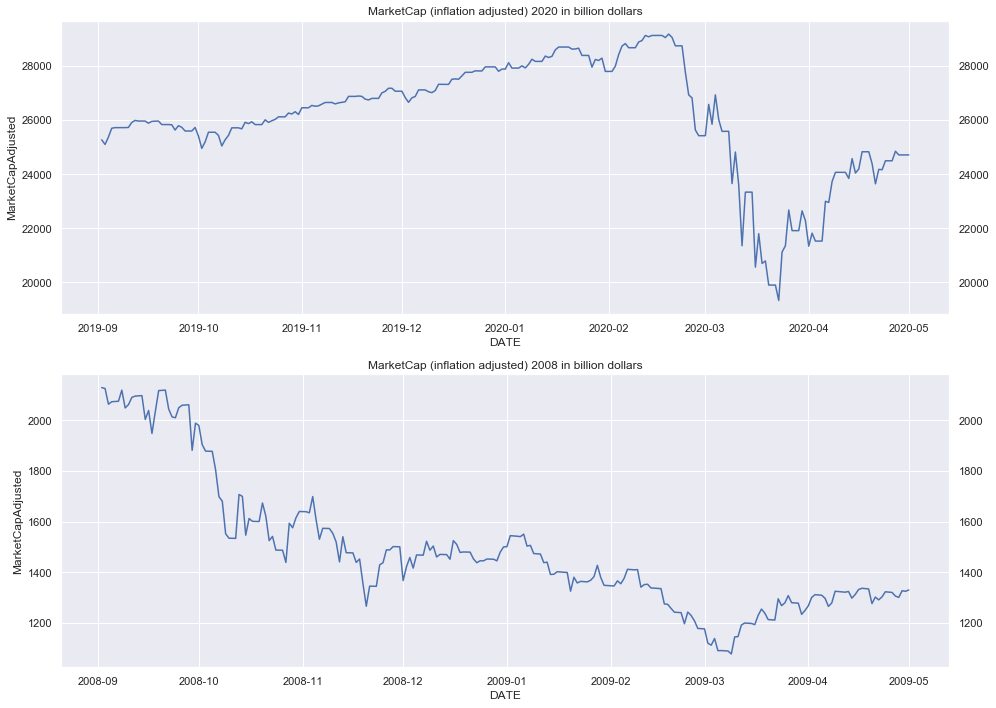

In [30]:
sns.set(rc={'figure.figsize':(14,10)})

fig, ax = plt.subplots(2)
xdata = np.arange(50)
sns.set(style="ticks")
g1 = sns.relplot(x='DATE', y='MarketCapAdjusted', kind='line',  data=res2020.reset_index(), ax=ax[0])
g2 = sns.relplot(x='DATE', y='MarketCapAdjusted', kind='line',  data=res2008.reset_index(), ax=ax[1])
ax[0].set_title("MarketCap (inflation adjusted) 2020 in billion dollars")
ax[1].set_title("MarketCap (inflation adjusted) 2008 in billion dollars")

# Close the additional empty figures returned by replot
plt.close(g1.fig)
plt.close(g2.fig) 
plt.tight_layout()

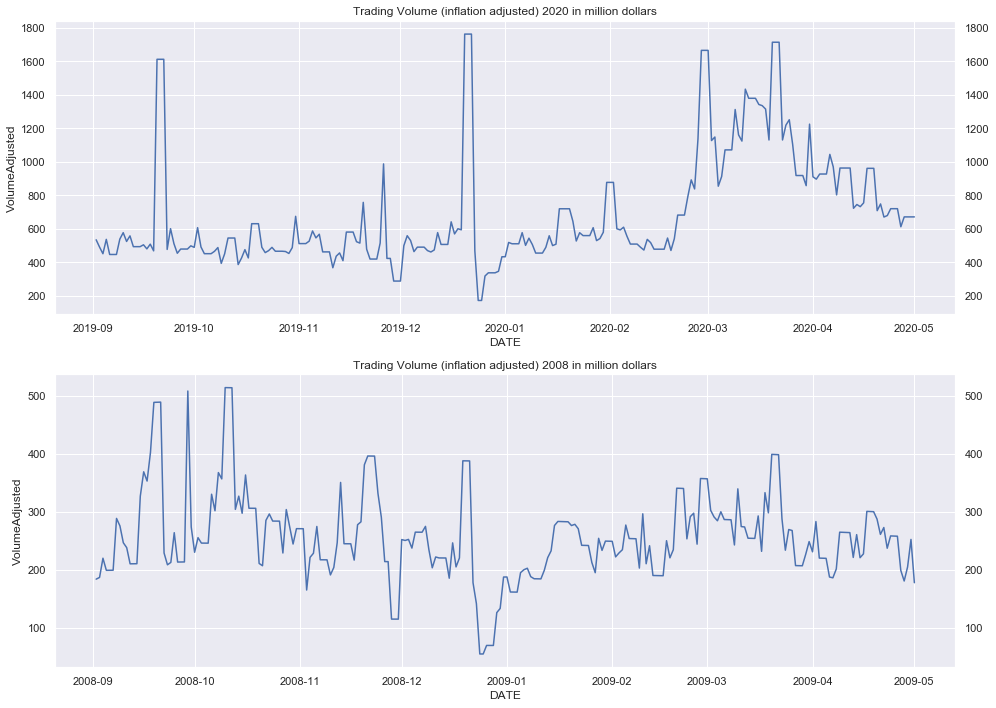

In [31]:
sns.set(rc={'figure.figsize':(14,10)})

fig, ax = plt.subplots(2)
xdata = np.arange(50)
sns.set(style="ticks")
g1 = sns.relplot(x='DATE', y='VolumeAdjusted', kind='line',  data=res2020.reset_index(), ax=ax[0])
g2 = sns.relplot(x='DATE', y='VolumeAdjusted', kind='line',  data=res2008.reset_index(), ax=ax[1])
ax[0].set_title("Trading Volume (inflation adjusted) 2020 in million dollars")
ax[1].set_title("Trading Volume (inflation adjusted) 2008 in million dollars")


# Close the additional empty figures returned by replot
plt.close(g1.fig)
plt.close(g2.fig) 
plt.tight_layout()


<p>The inflation-adjusted graphs tell perhaps a different story to the non-adjusted graphs above.<br/>
The drop in 2008 plays out as a relatively continuous event, with a clearly defined start- and end date.<br/>
Although there were some short-term ups and downs, there was an overall downward trend, which reversed almost precisely once Lehman collapsed.<br/>
Trading volumes were much more steady than in 2020.</p>

<p>In 2020, we see a lot of market volatility, with no clear market direction discernible at this moment in time. 
Looking at trading volume in USD, it's clear to see that they are overall much larger then in 2008, with nearly \$1,800m of turnover in December 2020, versus only \$600m turnover in October 2008.<br/>
I can only speculate with regards to the reasons. Obviously many stocks that form part of the S&P 500 have grown fervently over this 12-year period (think of Apple, Google, Tesla for example), contributing to a much larger market cap.<br/>
However, one question is where all that money comes from. I don't believe people's wages have increased proportionally to the S&P 500 growth (an interesting topic for analysis, but beyond the scope of this project), and as a result, it is unlikely that individual investors and pension funds are a major contributor to trading volumes. <br/>
My suspicion leads me to consider two factors as major contributors:
<ol>
<li>Smart ETFs are becoming increasingly popular. These ETFs balance their portfolio by certain criteria engrained in an algorithm, and will trade (potentially automatically) frequently to keep their constituents within those criteria. This could result in trades where previously a fund manager may not have traded in response to a market event.</li>
<li>Some partly private funds, like the <a href="https://blinks.bloomberg.com/screens PE21250 JP">Softbank Vision Fund</a> are making staggering amounts of money available to start-ups and companies in general, and that money is likely to find its way back into the stock market, either as part of such a companies investment strategy, or because that company itself ends up being listed on the stock market, with an arguably inflated valuation (<a href="https://blinks.bloomberg.com/screens WE US Equity">WeWork</a> almost did, but then didn't quite make it).
</li></ol></p>

    
<p>Coming back to the original question "Was (is) the coronavirus crisis worse than the mortgage crisis?", I think the short answer is that it is too early to make this analysis.<br/>
At the time of writing, the S&P 500 shows an upward trend, and trading volumes have normalized again. Looking at a 9-month period, the 2008 mortgage crisis so far looks worse in terms of loss relative to market capitalization, but the coronavirus crisis features a larger absolute drop, and overall more volatile trading volume (which may also indicate traders' uncertainty about what to do).</p>
    
<p>One surprising aspect, the effects of which I think we have yet to see, is that several governments have effectively acknowledged that there is no limit to the amount of cash they can generate (with incredibly large stimulus packages being approved on either side of the Atlantic).
Normally, we would expect such measures to lead to undesirable inflation. However, it will not be possible to test this until the lockdown is lifted, and people are able to spend money again.</p>


In [ ]:
%pwd